## Creat SimpleTrafficEnv

In [ ]:
import numpy as np

class SimpleTrafficEnv:
    """
    A minimal 2-phase traffic intersection simulator for baseline and RL experiments.
    Phase 0 = NS green
    Phase 1 = EW green
    """
    def __init__(self,
                 lambda_ns=0.3,
                 lambda_ew=0.3,
                 depart_rate=1,
                 max_time=3600):

        self.lambda_ns = lambda_ns
        self.lambda_ew = lambda_ew
        self.depart_rate = depart_rate
        self.max_time = max_time

        self.reset()

    def reset(self):
        # Queues
        self.q_ns = 0
        self.q_ew = 0

        # Time
        self.t = 0

        # Initial phase
        self.phase = 0

        # Statistics
        self.total_waiting_time = 0
        self.total_departed = 0
        self.cumulative_queue_ns = 0
        self.cumulative_queue_ew = 0

        return self._get_state()

    def _get_state(self):
        return {
            "t": self.t,
            "q_ns": self.q_ns,
            "q_ew": self.q_ew,
            "phase": self.phase
        }

    def step(self, phase):
        """
        Simulate one timestep.
        phase: 0 = NS green, 1 = EW green
        """
        self.phase = phase
        self.t += 1

        # 1) arrivals
        arrivals_ns = np.random.poisson(self.lambda_ns)
        arrivals_ew = np.random.poisson(self.lambda_ew)
        self.q_ns += arrivals_ns
        self.q_ew += arrivals_ew

        # 2) departure
        if self.phase == 0:  # NS green
            departed_ns = min(self.depart_rate, self.q_ns)
            self.q_ns -= departed_ns
            departed_ew = 0
        else:  # EW green
            departed_ew = min(self.depart_rate, self.q_ew)
            self.q_ew -= departed_ew
            departed_ns = 0

        # 3) update stats
        self.total_waiting_time += (self.q_ns + self.q_ew)
        self.total_departed += (departed_ns + departed_ew)
        self.cumulative_queue_ns += self.q_ns
        self.cumulative_queue_ew += self.q_ew

        done = (self.t >= self.max_time)
        return self._get_state(), done, {}

    def get_metrics(self):
        if self.total_departed > 0:
            avg_wait = self.total_waiting_time / self.total_departed
        else:
            avg_wait = None

        avg_q_ns = self.cumulative_queue_ns / self.t
        avg_q_ew = self.cumulative_queue_ew / self.t
        throughput = self.total_departed / self.t

        return {
            "avg_waiting_time": avg_wait,
            "avg_queue_ns": avg_q_ns,
            "avg_queue_ew": avg_q_ew,
            "throughput": throughput
        }


## Fixed-Time Baseline Controller

In [ ]:
def fixed_time_policy(t, cycle_length=60, green_ns=30):
    """
    Fixed-time traffic controller:
    - NS green for the first 30s
    - EW green for next 30s
    """
    t_mod = t % cycle_length
    if t_mod < green_ns:
        return 0  # NS green
    else:
        return 1  # EW green


def run_fixed_time_episode(env,
                           cycle_length=60,
                           green_ns=30):

    state = env.reset()
    done = False

    while not done:
        t = state["t"]
        phase = fixed_time_policy(t, cycle_length, green_ns)
        state, done, _ = env.step(phase)

    return env.get_metrics()


def evaluate_fixed_time(num_episodes=5,
                        lambda_ns=0.3,
                        lambda_ew=0.3):

    metrics_all = []

    for _ in range(num_episodes):
        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=3600)

        metrics = run_fixed_time_episode(env)
        metrics_all.append(metrics)

    avg = {}
    keys = metrics_all[0].keys()
    for k in keys:
        vals = [m[k] for m in metrics_all if m[k] is not None]
        avg[k] = sum(vals) / len(vals)

    return avg


## Heuristic / Actuated Baseline

In [ ]:
class HeuristicController:
    """
    A simple actuated controller:
    - Minimum green time
    - Switch only if opposing queue is much longer
    """
    def __init__(self, min_green=10, switch_threshold=3):
        self.min_green = min_green
        self.switch_threshold = switch_threshold
        self.current_phase = 0
        self.phase_elapsed = 0

    def reset(self):
        self.current_phase = 0
        self.phase_elapsed = 0

    def act(self, state):
        q_ns = state["q_ns"]
        q_ew = state["q_ew"]

        # update timer
        self.phase_elapsed += 1

        # must satisfy minimum green
        if self.phase_elapsed < self.min_green:
            return self.current_phase

        # evaluate switching
        if self.current_phase == 0:  # NS green
            if (q_ew - q_ns) >= self.switch_threshold:
                self.current_phase = 1
                self.phase_elapsed = 0
        else:  # EW green
            if (q_ns - q_ew) >= self.switch_threshold:
                self.current_phase = 0
                self.phase_elapsed = 0

        return self.current_phase


def run_heuristic_episode(env,
                          min_green=10,
                          switch_threshold=3):
    controller = HeuristicController(min_green=min_green,
                                     switch_threshold=switch_threshold)
    controller.reset()

    state = env.reset()
    done = False

    while not done:
        phase = controller.act(state)
        state, done, _ = env.step(phase)

    return env.get_metrics()


def evaluate_heuristic(num_episodes=5,
                       lambda_ns=0.3,
                       lambda_ew=0.3):

    metrics_all = []

    for _ in range(num_episodes):
        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=3600)

        metrics = run_heuristic_episode(env)
        metrics_all.append(metrics)

    avg = {}
    keys = metrics_all[0].keys()
    for k in keys:
        vals = [m[k] for m in metrics_all if m[k] is not None]
        avg[k] = sum(vals) / len(vals)

    return avg


In [ ]:
print("Running baselines...")

fixed = evaluate_fixed_time()
heuristic = evaluate_heuristic()

print("\n=== Fixed-Time Baseline ===")
for k, v in fixed.items():
    print(f"{k}: {v:.4f}")

print("\n=== Heuristic Baseline ===")
for k, v in heuristic.items():
    print(f"{k}: {v:.4f}")


Running baselines...

=== Fixed-Time Baseline ===
avg_waiting_time: 11.6671
avg_queue_ns: 3.4148
avg_queue_ew: 3.5324
throughput: 0.5954

=== Heuristic Baseline ===
avg_waiting_time: 4.3800
avg_queue_ns: 1.3574
avg_queue_ew: 1.3205
throughput: 0.6112


## A. Tabular Q-learning RL Controller
1.Add a discretization and state utility function

In [ ]:
import numpy as np

# Discretize queue length into bins
def discretize_queue(q):
    """
    Map queue length to a small discrete bucket.
    You can tune the thresholds later.
    """
    if q == 0:
        return 0
    elif q <= 2:
        return 1
    elif q <= 5:
        return 2
    elif q <= 10:
        return 3
    else:
        return 4

NUM_Q_BINS = 5   # 0,1,2,3,4 as above
NUM_PHASES = 2   # 0=NS, 1=EW
NUM_ACTIONS = 2  # 0=stay, 1=switch

def get_discrete_state_idx(env_state, phase):
    """
    Convert (q_ns, q_ew, phase) into a single integer state index.
    For tabular Q-learning.
    """
    q_ns = env_state["q_ns"]
    q_ew = env_state["q_ew"]

    b_ns = discretize_queue(q_ns)
    b_ew = discretize_queue(q_ew)

    # 3D index -> flat index
    idx = (b_ns * NUM_Q_BINS * NUM_PHASES) + (b_ew * NUM_PHASES) + phase
    return idx


2.Q-learning training function

In [ ]:
def q_learning_train(
    num_episodes=200,
    max_time=3600,
    gamma=0.99,
    alpha=0.1,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_episodes=150,
    lambda_ns=0.3,
    lambda_ew=0.3
):
    """
    Tabular Q-learning controller with:
    - state: discretized (queue_NS, queue_EW) + phase
    - action: 0 = stay, 1 = switch
    """
    num_states = NUM_Q_BINS * NUM_Q_BINS * NUM_PHASES
    Q = np.zeros((num_states, NUM_ACTIONS), dtype=np.float32)

    episode_rewards = []

    for ep in range(num_episodes):
        # Linear epsilon decay
        eps = max(
            eps_end,
            eps_start - (eps_start - eps_end) * ep / max(1, eps_decay_episodes)
        )

        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        env_state = env.reset()

        # RL's own phase & timer
        phase = 0  # start with NS green
        phase_elapsed = 0

        state_idx = get_discrete_state_idx(env_state, phase)
        total_reward = 0.0

        done = False

        while not done:
            # epsilon-greedy action selection
            if np.random.rand() < eps:
                action = np.random.randint(NUM_ACTIONS)
            else:
                action = np.argmax(Q[state_idx])

            # translate action -> new phase
            if action == 0:
                # stay
                phase_new = phase
                phase_elapsed += 1
            else:
                # switch
                phase_new = 1 - phase
                phase_elapsed = 1  # reset timer after switching

            # step the environment using the chosen phase
            next_env_state, done, _ = env.step(phase_new)

            # define reward: negative total queue length
            reward = - (next_env_state["q_ns"] + next_env_state["q_ew"])
            total_reward += reward

            # compute next state index
            next_state_idx = get_discrete_state_idx(next_env_state, phase_new)

            # TD target
            if done:
                target = reward
            else:
                target = reward + gamma * np.max(Q[next_state_idx])

            # Q update
            Q[state_idx, action] = (1 - alpha) * Q[state_idx, action] + alpha * target

            # move to next
            state_idx = next_state_idx
            phase = phase_new

        episode_rewards.append(total_reward)

        if (ep + 1) % 20 == 0:
            print(f"Episode {ep+1}/{num_episodes}, eps={eps:.3f}, total_reward={total_reward:.1f}")

    return Q, episode_rewards


3.Use the trained Q-table to evaluate the RL controller

In [ ]:
def q_learning_policy(Q, env_state, phase):
    """
    Greedy policy based on learned Q-table.
    """
    state_idx = get_discrete_state_idx(env_state, phase)
    action = np.argmax(Q[state_idx])
    return action

def evaluate_q_learning(Q,
                        num_episodes=5,
                        max_time=3600,
                        lambda_ns=0.3,
                        lambda_ew=0.3):
    metrics_all = []
    for _ in range(num_episodes):
        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        env_state = env.reset()
        phase = 0
        phase_elapsed = 0
        done = False

        while not done:
            action = q_learning_policy(Q, env_state, phase)
            if action == 0:
                phase_new = phase
                phase_elapsed += 1
            else:
                phase_new = 1 - phase
                phase_elapsed = 1

            env_state, done, _ = env.step(phase_new)
            phase = phase_new

        metrics_all.append(env.get_metrics())

    avg = {}
    keys = metrics_all[0].keys()
    for k in keys:
        vals = [m[k] for m in metrics_all if m[k] is not None]
        avg[k] = sum(vals) / len(vals)
    return avg


4.Training + comparing with baseline

In [ ]:
# 1) train Q-learning
Q, rewards = q_learning_train(
    num_episodes=200,
    max_time=600,      # 先用短一点的仿真时间，让训练快点
    lambda_ns=0.3,
    lambda_ew=0.3
)

# 2) evaluate RL vs baselines (都用同样的 max_time)
fixed = evaluate_fixed_time(num_episodes=5, lambda_ns=0.3, lambda_ew=0.3)
heur = evaluate_heuristic(num_episodes=5, lambda_ns=0.3, lambda_ew=0.3)
rl_q = evaluate_q_learning(Q, num_episodes=5, max_time=600,
                           lambda_ns=0.3, lambda_ew=0.3)

print("\n=== Fixed-Time Baseline ===")
for k, v in fixed.items():
    print(f"{k}: {v:.4f}")

print("\n=== Heuristic Baseline ===")
for k, v in heur.items():
    print(f"{k}: {v:.4f}")

print("\n=== Q-Learning RL Controller ===")
for k, v in rl_q.items():
    print(f"{k}: {v:.4f}")


Episode 20/200, eps=0.880, total_reward=-1169.0
Episode 40/200, eps=0.753, total_reward=-728.0
Episode 60/200, eps=0.626, total_reward=-614.0
Episode 80/200, eps=0.500, total_reward=-572.0
Episode 100/200, eps=0.373, total_reward=-756.0
Episode 120/200, eps=0.246, total_reward=-624.0
Episode 140/200, eps=0.120, total_reward=-614.0
Episode 160/200, eps=0.050, total_reward=-439.0
Episode 180/200, eps=0.050, total_reward=-464.0
Episode 200/200, eps=0.050, total_reward=-391.0

=== Fixed-Time Baseline ===
avg_waiting_time: 11.1606
avg_queue_ns: 3.2819
avg_queue_ew: 3.4193
throughput: 0.6004

=== Heuristic Baseline ===
avg_waiting_time: 4.3582
avg_queue_ns: 1.2881
avg_queue_ew: 1.3316
throughput: 0.6004

=== Q-Learning RL Controller ===
avg_waiting_time: 1.3065
avg_queue_ns: 0.2287
avg_queue_ew: 0.5507
throughput: 0.5957


## B.DQN (Deep Q-Network) Implementation (Continuous State)

1.Import PyTorch, and define the network & Replay Buffer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# State: [q_ns, q_ew, phase, phase_elapsed]
STATE_DIM = 4
ACTION_DIM = 2  # stay, switch

class DQN(nn.Module):
    def __init__(self, state_dim=STATE_DIM, action_dim=ACTION_DIM):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, d = zip(*batch)
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.long, device=device),
            torch.tensor(r, dtype=torch.float32, device=device),
            torch.tensor(s_next, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device),
        )
    def __len__(self):
        return len(self.buffer)


2. Combine env_state, phase, and phase_elapsed into a continuous state vector

In [ ]:
def get_continuous_state(env_state, phase, phase_elapsed):
    """
    Convert current environment info into a continuous state vector for DQN.
    """
    return np.array([
        env_state["q_ns"],
        env_state["q_ew"],
        phase,
        phase_elapsed
    ], dtype=np.float32)


3.DQN Training Function

In [ ]:
def dqn_train(
    num_episodes=200,
    max_time=600,
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    buffer_capacity=50000,
    min_buffer_size=1000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_episodes=150,
    target_update_freq=200,
    lambda_ns=0.3,
    lambda_ew=0.3
):
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=buffer_capacity)

    steps_done = 0
    episode_rewards = []

    for ep in range(num_episodes):
        # epsilon schedule by episode
        eps = max(
            eps_end,
            eps_start - (eps_start - eps_end) * ep / max(1, eps_decay_episodes)
        )

        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        env_state = env.reset()
        phase = 0
        phase_elapsed = 0

        state = get_continuous_state(env_state, phase, phase_elapsed)
        total_reward = 0.0
        done = False

        while not done:
            # epsilon-greedy action
            if random.random() < eps:
                action = random.randrange(ACTION_DIM)
            else:
                with torch.no_grad():
                    s_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    q_values = policy_net(s_tensor)
                    action = int(torch.argmax(q_values, dim=1).item())

            # translate action to phase
            if action == 0:
                phase_new = phase
                phase_elapsed += 1
            else:
                phase_new = 1 - phase
                phase_elapsed = 1

            # env step
            next_env_state, done, _ = env.step(phase_new)
            next_state = get_continuous_state(next_env_state, phase_new, phase_elapsed)

            # reward
            reward = - (next_env_state["q_ns"] + next_env_state["q_ew"])
            total_reward += reward

            # store transition
            replay_buffer.push(state, action, reward, next_state, float(done))
            state = next_state
            phase = phase_new

            steps_done += 1

            # update network if enough data
            if len(replay_buffer) >= min_buffer_size:
                s_batch, a_batch, r_batch, s_next_batch, d_batch = replay_buffer.sample(batch_size)

                # Q(s,a)
                q_values = policy_net(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)

                # max_a' Q_target(s',a')
                with torch.no_grad():
                    q_next = target_net(s_next_batch).max(1)[0]
                    target = r_batch + gamma * (1 - d_batch) * q_next

                loss = nn.MSELoss()(q_values, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update target net periodically
                if steps_done % target_update_freq == 0:
                    target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)

        if (ep + 1) % 20 == 0:
            print(f"[DQN] Episode {ep+1}/{num_episodes}, eps={eps:.3f}, total_reward={total_reward:.1f}")

    return policy_net, episode_rewards


4. Use the trained DQN for evaluation

In [ ]:
def dqn_policy(policy_net, env_state, phase, phase_elapsed):
    state = get_continuous_state(env_state, phase, phase_elapsed)
    with torch.no_grad():
        s_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = policy_net(s_tensor)
        action = int(torch.argmax(q_values, dim=1).item())
    return action

def evaluate_dqn(policy_net,
                 num_episodes=5,
                 max_time=600,
                 lambda_ns=0.3,
                 lambda_ew=0.3):
    metrics_all = []
    for _ in range(num_episodes):
        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        env_state = env.reset()
        phase = 0
        phase_elapsed = 0
        done = False

        while not done:
            action = dqn_policy(policy_net, env_state, phase, phase_elapsed)
            if action == 0:
                phase_new = phase
                phase_elapsed += 1
            else:
                phase_new = 1 - phase
                phase_elapsed = 1

            env_state, done, _ = env.step(phase_new)
            phase = phase_new

        metrics_all.append(env.get_metrics())

    avg = {}
    keys = metrics_all[0].keys()
    for k in keys:
        vals = [m[k] for m in metrics_all if m[k] is not None]
        avg[k] = sum(vals) / len(vals)
    return avg


5.Train DQN+ and compare with Baseline / Q-learning

In [ ]:
# Train DQN
policy_net, dqn_rewards = dqn_train(
    num_episodes=200,
    max_time=600,
    lambda_ns=0.3,
    lambda_ew=0.3
)

# Evaluate
fixed = evaluate_fixed_time(num_episodes=5, lambda_ns=0.3, lambda_ew=0.3)
heur = evaluate_heuristic(num_episodes=5, lambda_ns=0.3, lambda_ew=0.3)
rl_q = evaluate_q_learning(Q, num_episodes=5, max_time=600,
                           lambda_ns=0.3, lambda_ew=0.3)
rl_dqn = evaluate_dqn(policy_net, num_episodes=5, max_time=600,
                      lambda_ns=0.3, lambda_ew=0.3)

print("\n=== Fixed-Time Baseline ===")
for k, v in fixed.items():
    print(f"{k}: {v:.4f}")

print("\n=== Heuristic Baseline ===")
for k, v in heur.items():
    print(f"{k}: {v:.4f}")

print("\n=== Q-Learning RL Controller ===")
for k, v in rl_q.items():
    print(f"{k}: {v:.4f}")

print("\n=== DQN RL Controller ===")
for k, v in rl_dqn.items():
    print(f"{k}: {v:.4f}")


/tmp/ipython-input-3239852649.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(s, dtype=torch.float32, device=device),


[DQN] Episode 20/200, eps=0.880, total_reward=-1152.0
[DQN] Episode 40/200, eps=0.753, total_reward=-713.0
[DQN] Episode 60/200, eps=0.626, total_reward=-685.0
[DQN] Episode 80/200, eps=0.500, total_reward=-718.0
[DQN] Episode 100/200, eps=0.373, total_reward=-732.0
[DQN] Episode 120/200, eps=0.246, total_reward=-624.0
[DQN] Episode 140/200, eps=0.120, total_reward=-399.0
[DQN] Episode 160/200, eps=0.050, total_reward=-497.0
[DQN] Episode 180/200, eps=0.050, total_reward=-578.0
[DQN] Episode 200/200, eps=0.050, total_reward=-384.0

=== Fixed-Time Baseline ===
avg_waiting_time: 11.4640
avg_queue_ns: 3.4112
avg_queue_ew: 3.3972
throughput: 0.5938

=== Heuristic Baseline ===
avg_waiting_time: 4.3554
avg_queue_ns: 1.2752
avg_queue_ew: 1.3011
throughput: 0.5910

=== Q-Learning RL Controller ===
avg_waiting_time: 20.6150
avg_queue_ns: 0.2413
avg_queue_ew: 8.5317
throughput: 0.5717

=== DQN RL Controller ===
avg_waiting_time: 1.0870
avg_queue_ns: 0.3233
avg_queue_ew: 0.3257
throughput: 0.5923

## Evaluation: Comparison of Multiple Traffic Scenarios

In [ ]:
def evaluate_controller(controller_name, Q=None, policy_net=None,
                        lambda_ns=0.3, lambda_ew=0.3, max_time=600):

    if controller_name == "fixed":
        return evaluate_fixed_time(num_episodes=5, lambda_ns=lambda_ns, lambda_ew=lambda_ew)

    if controller_name == "heuristic":
        return evaluate_heuristic(num_episodes=5, lambda_ns=lambda_ns, lambda_ew=lambda_ew)

    if controller_name == "q_learning":
        return evaluate_q_learning(Q, num_episodes=5, max_time=max_time,
                                   lambda_ns=lambda_ns, lambda_ew=lambda_ew)

    if controller_name == "dqn":
        return evaluate_dqn(policy_net, num_episodes=5, max_time=max_time,
                            lambda_ns=lambda_ns, lambda_ew=lambda_ew)

    raise ValueError("Unknown controller:", controller_name)


In [ ]:
import pandas as pd

def run_multi_scenario_experiments(Q, policy_net):
    scenarios = {
        "Balanced (0.3, 0.3)": (0.3, 0.3),
        "NS Heavy (0.6, 0.2)": (0.6, 0.2),
        "EW Heavy (0.2, 0.6)": (0.2, 0.6),
    }

    controllers = ["fixed", "heuristic", "q_learning", "dqn"]

    results = []

    for scen_name, (lam_ns, lam_ew) in scenarios.items():
        print(f"\n=== Scenario: {scen_name} ===")
        for ctrl in controllers:
            metrics = evaluate_controller(ctrl, Q=Q, policy_net=policy_net,
                                          lambda_ns=lam_ns, lambda_ew=lam_ew)

            results.append({
                "Scenario": scen_name,
                "Controller": ctrl,
                "avg_waiting_time": metrics["avg_waiting_time"],
                "avg_queue_ns": metrics["avg_queue_ns"],
                "avg_queue_ew": metrics["avg_queue_ew"],
                "throughput": metrics["throughput"],
            })

            print(f"{ctrl:12s}  waiting={metrics['avg_waiting_time']:.3f}, "
                  f"q_ns={metrics['avg_queue_ns']:.3f}, "
                  f"q_ew={metrics['avg_queue_ew']:.3f}")

    return pd.DataFrame(results)

df_results = run_multi_scenario_experiments(Q, policy_net)
df_results



=== Scenario: Balanced (0.3, 0.3) ===
fixed         waiting=11.555, q_ns=3.412, q_ew=3.524
heuristic     waiting=4.305, q_ns=1.265, q_ew=1.320
q_learning    waiting=1.257, q_ns=0.245, q_ew=0.513
dqn           waiting=1.183, q_ns=0.369, q_ew=0.323

=== Scenario: NS Heavy (0.6, 0.2) ===
fixed         waiting=277.016, q_ns=191.448, q_ew=2.070
heuristic     waiting=6.938, q_ns=3.957, q_ew=1.593
q_learning    waiting=1.742, q_ns=0.905, q_ew=0.450
dqn           waiting=2.681, q_ns=1.871, q_ew=0.291

=== Scenario: EW Heavy (0.2, 0.6) ===
fixed         waiting=278.344, q_ns=1.993, q_ew=191.616
heuristic     waiting=6.910, q_ns=1.571, q_ew=3.942
q_learning    waiting=165.389, q_ns=0.196, q_ew=59.781
dqn           waiting=2.799, q_ns=0.494, q_ew=1.682


,Scenario,Controller,avg_waiting_time,avg_queue_ns,avg_queue_ew,throughput
0,"Balanced (0.3, 0.3)",fixed,11.554810,3.412444,3.524000,0.600278
1,"Balanced (0.3, 0.3)",heuristic,4.304650,1.264667,1.319722,0.600333
2,"Balanced (0.3, 0.3)",q_learning,1.256520,0.245000,0.513000,0.600000
3,"Balanced (0.3, 0.3)",dqn,1.183333,0.368667,0.323333,0.585667
4,"NS Heavy (0.6, 0.2)",fixed,277.016058,191.448222,2.069722,0.699056
5,"NS Heavy (0.6, 0.2)",heuristic,6.938140,3.956556,1.592667,0.799389
6,"NS Heavy (0.6, 0.2)",q_learning,1.741765,0.905000,0.450333,0.777333
7,"NS Heavy (0.6, 0.2)",dqn,2.681037,1.871000,0.290667,0.803667
8,"EW Heavy (0.2, 0.6)",fixed,278.343756,1.992889,191.616111,0.695833
9,"EW Heavy (0.2, 0.6)",heuristic,6.909935,1.571167,3.942444,0.796778


## Plot the learning curve of DQN (reward vs episode)

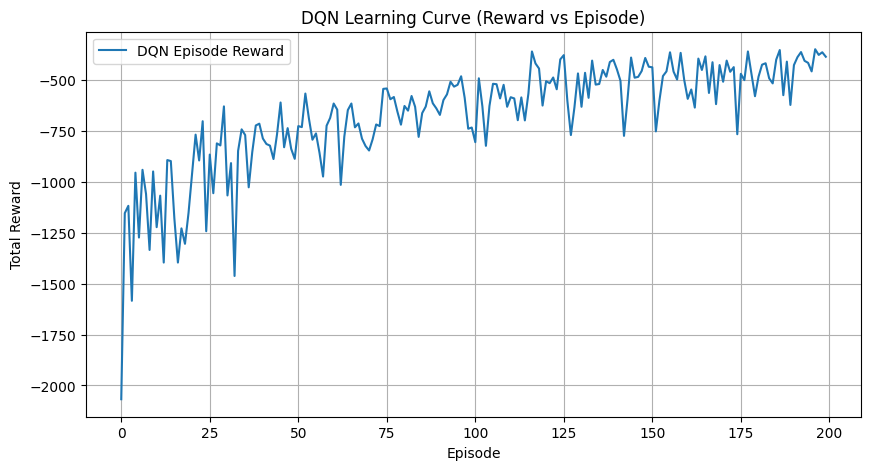

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(dqn_rewards, label="DQN Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Learning Curve (Reward vs Episode)")
plt.grid(True)
plt.legend()
plt.show()


## Sensitivity Experiment: Testing the Impact of Different γ on RL Performance

In [ ]:
import pandas as pd

gammas = [0.90, 0.95, 0.99]
results_gamma = []

for g in gammas:
    print(f"\n=== Training Q-learning with gamma={g} ===")
    Qg, rew = q_learning_train(
        num_episodes=200,
        max_time=600,
        gamma=g,
        lambda_ns=0.3,
        lambda_ew=0.3
    )

    metrics = evaluate_q_learning(
        Qg, num_episodes=5, max_time=600,
        lambda_ns=0.3, lambda_ew=0.3
    )
    metrics["gamma"] = g
    results_gamma.append(metrics)

df_gamma = pd.DataFrame(results_gamma)
df_gamma




=== Training Q-learning with gamma=0.9 ===
Episode 20/200, eps=0.880, total_reward=-1360.0
Episode 40/200, eps=0.753, total_reward=-770.0
Episode 60/200, eps=0.626, total_reward=-817.0
Episode 80/200, eps=0.500, total_reward=-696.0
Episode 100/200, eps=0.373, total_reward=-891.0
Episode 120/200, eps=0.246, total_reward=-833.0
Episode 140/200, eps=0.120, total_reward=-434.0
Episode 160/200, eps=0.050, total_reward=-431.0
Episode 180/200, eps=0.050, total_reward=-526.0
Episode 200/200, eps=0.050, total_reward=-538.0

=== Training Q-learning with gamma=0.95 ===
Episode 20/200, eps=0.880, total_reward=-1063.0
Episode 40/200, eps=0.753, total_reward=-1317.0
Episode 60/200, eps=0.626, total_reward=-894.0
Episode 80/200, eps=0.500, total_reward=-590.0
Episode 100/200, eps=0.373, total_reward=-564.0
Episode 120/200, eps=0.246, total_reward=-743.0
Episode 140/200, eps=0.120, total_reward=-399.0
Episode 160/200, eps=0.050, total_reward=-486.0
Episode 180/200, eps=0.050, total_reward=-442.0
Epis

,avg_waiting_time,avg_queue_ns,avg_queue_ew,throughput,gamma
0,1.317883,0.422,0.372333,0.603667,0.90
1,1.272210,0.401,0.372667,0.605000,0.95
2,1.220579,0.415,0.307000,0.591000,0.99


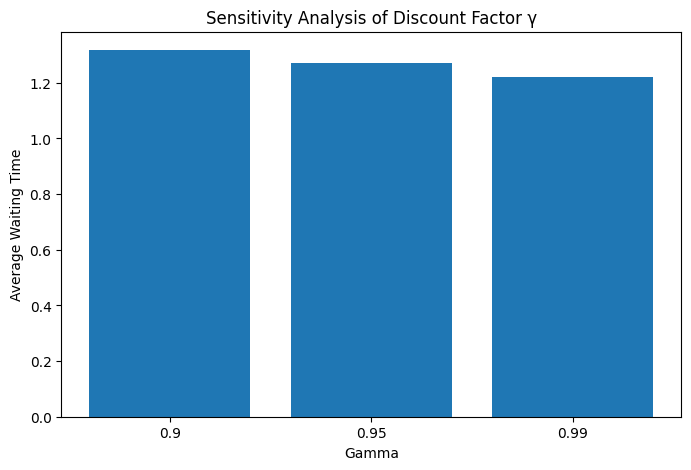

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df_gamma["gamma"].astype(str), df_gamma["avg_waiting_time"])
plt.xlabel("Gamma")
plt.ylabel("Average Waiting Time")
plt.title("Sensitivity Analysis of Discount Factor γ")
plt.show()


Ablation Study

Original state index

In [ ]:
def get_discrete_state_idx(env_state, phase):
    b_ns = discretize_queue(env_state["q_ns"])
    b_ew = discretize_queue(env_state["q_ew"])
    idx = (b_ns * NUM_Q_BINS * NUM_PHASES) + (b_ew * NUM_PHASES) + phase
    return idx



Evaluation

In [ ]:
def evaluate_q(Q, max_time=600, lambda_ns=0.3, lambda_ew=0.3):
    from copy import deepcopy

    metrics_all = []
    for _ in range(5):
        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        state = env.reset()
        phase = 0
        done = False

        while not done:
            s_idx = get_discrete_state_idx(state, phase)
            action = np.argmax(Q[s_idx])
            phase_new = phase if action == 0 else 1-phase
            state, done, _ = env.step(phase_new)
            phase = phase_new

        metrics_all.append(env.get_metrics())

    # average
    avg = {}
    for k in metrics_all[0].keys():
        avg[k] = np.mean([m[k] for m in metrics_all])
    return avg


1）Ablation 1：State no phase

In [ ]:
def get_state_no_phase(env_state):
    b_ns = discretize_queue(env_state["q_ns"])
    b_ew = discretize_queue(env_state["q_ew"])
    return b_ns * NUM_Q_BINS + b_ew


Ablation 1 Q-learning

In [ ]:
def q_learning_train_no_phase(
    num_episodes=200,
    max_time=600,
    gamma=0.99,
    alpha=0.1,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_episodes=150,
    lambda_ns=0.3,
    lambda_ew=0.3
):
    num_states = NUM_Q_BINS * NUM_Q_BINS
    Q = np.zeros((num_states, NUM_ACTIONS))

    rewards_history = []

    for ep in range(num_episodes):

        eps = max(
            eps_end,
            eps_start - (eps_start - eps_end) * ep / eps_decay_episodes
        )

        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        state = env.reset()
        phase = 0
        done = False

        s_idx = get_state_no_phase(state)
        total_reward = 0

        while not done:

            if np.random.rand() < eps:
                action = np.random.randint(NUM_ACTIONS)
            else:
                action = np.argmax(Q[s_idx])

            phase_new = phase if action == 0 else 1 - phase
            next_state, done, _ = env.step(phase_new)

            reward = - (next_state["q_ns"] + next_state["q_ew"])
            total_reward += reward

            s_idx_new = get_state_no_phase(next_state)

            target = reward if done else reward + gamma * np.max(Q[s_idx_new])
            Q[s_idx, action] = (1-alpha)*Q[s_idx, action] + alpha*target

            s_idx = s_idx_new
            phase = phase_new

        rewards_history.append(total_reward)

        if (ep+1)%20 == 0:
            print(f"[Ablation1] Episode {ep+1}/200 reward={total_reward}")

    return Q, rewards_history


2）Ablation 2：Weighted Queue Reward（奖励加倍）

In [ ]:
def q_learning_train_weighted_reward(
    num_episodes=200,
    max_time=600,
    gamma=0.99,
    alpha=0.1,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_episodes=150,
    lambda_ns=0.3,
    lambda_ew=0.3
):
    num_states = NUM_Q_BINS * NUM_Q_BINS * NUM_PHASES
    Q = np.zeros((num_states, NUM_ACTIONS))
    rewards_history = []

    for ep in range(num_episodes):

        eps = max(eps_end, eps_start - (eps_start-eps_end)*ep/eps_decay_episodes)

        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)
        state = env.reset()
        phase = 0
        done = False

        s_idx = get_discrete_state_idx(state, phase)
        total_reward = 0

        while not done:
            if np.random.rand() < eps:
                action = np.random.randint(NUM_ACTIONS)
            else:
                action = np.argmax(Q[s_idx])

            phase_new = phase if action == 0 else 1-phase
            next_state, done, _ = env.step(phase_new)

            reward = - (2*next_state["q_ns"] + 2*next_state["q_ew"])
            total_reward += reward

            s_idx_new = get_discrete_state_idx(next_state, phase_new)

            target = reward if done else reward + gamma * np.max(Q[s_idx_new])
            Q[s_idx, action] = (1-alpha)*Q[s_idx, action] + alpha*target

            s_idx = s_idx_new
            phase = phase_new

        rewards_history.append(total_reward)

        if (ep+1)%20 == 0:
            print(f"[Ablation2] Episode {ep+1}/200 reward={total_reward}")

    return Q, rewards_history



Ablation 2 Q-learning

In [ ]:
def evaluate_q_no_phase(Q,
                        max_time=600,
                        lambda_ns=0.3,
                        lambda_ew=0.3):
    metrics_all = []
    for _ in range(5):
        env = SimpleTrafficEnv(lambda_ns=lambda_ns,
                               lambda_ew=lambda_ew,
                               depart_rate=1,
                               max_time=max_time)

        state = env.reset()
        phase = 0
        done = False

        while not done:
            s_idx = get_state_no_phase(state)
            action = np.argmax(Q[s_idx])

            # action->phase
            phase_new = phase if action == 0 else 1-phase

            state, done, _ = env.step(phase_new)
            phase = phase_new

        metrics_all.append(env.get_metrics())

    avg = {}
    keys = metrics_all[0].keys()
    for k in keys:
        avg[k] = np.mean([m[k] for m in metrics_all])
    return avg


In [ ]:
# 1. Original Q-learning
Q_orig, _ = q_learning_train(num_episodes=200, max_time=600)
metrics_orig = evaluate_q(Q_orig)

# 2. Ablation 1 — No Phase
Q_nophase, _ = q_learning_train_no_phase(num_episodes=200, max_time=600)
metrics_nophase = evaluate_q_no_phase(Q_nophase)

# 3. Ablation 2 — Weighted Reward
Q_weight, _ = q_learning_train_weighted_reward(num_episodes=200, max_time=600)
metrics_weight = evaluate_q(Q_weight)


Episode 20/200, eps=0.880, total_reward=-877.0
Episode 40/200, eps=0.753, total_reward=-893.0
Episode 60/200, eps=0.626, total_reward=-654.0
Episode 80/200, eps=0.500, total_reward=-805.0
Episode 100/200, eps=0.373, total_reward=-520.0
Episode 120/200, eps=0.246, total_reward=-512.0
Episode 140/200, eps=0.120, total_reward=-673.0
Episode 160/200, eps=0.050, total_reward=-440.0
Episode 180/200, eps=0.050, total_reward=-401.0
Episode 200/200, eps=0.050, total_reward=-456.0
[Ablation1] Episode 20/200 reward=-1462
[Ablation1] Episode 40/200 reward=-1111
[Ablation1] Episode 60/200 reward=-805
[Ablation1] Episode 80/200 reward=-960
[Ablation1] Episode 100/200 reward=-797
[Ablation1] Episode 120/200 reward=-586
[Ablation1] Episode 140/200 reward=-986
[Ablation1] Episode 160/200 reward=-705
[Ablation1] Episode 180/200 reward=-761
[Ablation1] Episode 200/200 reward=-983
[Ablation2] Episode 20/200 reward=-1770
[Ablation2] Episode 40/200 reward=-2042
[Ablation2] Episode 60/200 reward=-950
[Ablati